## 0. Loading Lib

In [1]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import ultralytics

ultralytics.checks()

Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.2/112.6 GB disk)


In [3]:
import os

import matplotlib.pyplot as plt
import timm
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms

## 1. Load model

In [4]:
from ultralytics import YOLO

text_det_model_path = "/content/Detection.pt"
yolo = YOLO(text_det_model_path)

In [5]:
class CRNN(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        backbone = timm.create_model("resnet34", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(dropout)
        )

        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2)
        )

    @torch.autocast(device_type="cuda")
    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the feature map
        x = self.mapSeq(x)
        x, _ = self.gru(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  # Based on CTC

        return x

In [6]:
chars = "0123456789abcdefghijklmnopqrstuvwxyz-"
vocab_size = len(chars)
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [7]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = '/content/ocr_crnn.pt'
crnn_model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers,
).to(device)
crnn_model.load_state_dict(torch.load(model_path))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

<All keys matched successfully>

## 2.Inference

In [8]:
def decode(encoded_sequences, idx_to_char, blank_char="-"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None  # To track the previous character

        for token in seq:
            if token != 0:  # Ignore padding (token = 0)
                char = idx_to_char[token.item()]
                # Append the character if it's not a blank or the same as the previous character
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char  # Update previous character

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences

In [9]:
def text_detection(img_path, text_det_model):
    text_det_results = text_det_model(img_path, verbose=False)[0]

    bboxes = text_det_results.boxes.xyxy.tolist()
    classes = text_det_results.boxes.cls.tolist()
    names = text_det_results.names
    confs = text_det_results.boxes.conf.tolist()

    return bboxes, classes, names, confs

In [10]:
def text_recognition(img, data_transforms, text_reg_model, idx_to_char, device):
    transformed_image = data_transforms(img)
    transformed_image = transformed_image.unsqueeze(0).to(device)
    text_reg_model.eval()
    with torch.no_grad():
        logits = text_reg_model(transformed_image).detach().cpu()
    text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)

    return text

In [11]:
def visualize_detections(img, detections):
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")

    for bbox, detected_class, confidence, transcribed_text in detections:
        x1, y1, x2, y2 = bbox
        plt.gca().add_patch(
            plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=2
            )
        )
        plt.text(
            x1,
            y1 - 10,
            f"{detected_class} ({confidence:.2f}): {transcribed_text}",
            fontsize=9,
            bbox=dict(facecolor="red", alpha=0.5),
        )

    plt.show()

In [12]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.Grayscale(num_output_channels=1),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(degrees=1, shear=1),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=3),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}


def predict(
    img_path, data_transforms, text_det_model, text_reg_model, idx_to_char, device
):
    # Detection
    bboxes, classes, names, confs = text_detection(img_path, text_det_model)

    # Load the image
    img = Image.open(img_path)

    predictions = []

    # Iterate through the results
    for bbox, cls, conf in zip(bboxes, classes, confs):
        x1, y1, x2, y2 = bbox
        confidence = conf
        detected_class = cls
        name = names[int(cls)]

        # Extract the detected object and crop it
        cropped_image = img.crop((x1, y1, x2, y2))

        transcribed_text = text_recognition(
            cropped_image, data_transforms, text_reg_model, idx_to_char, device
        )

        predictions.append((bbox, name, confidence, transcribed_text))

    visualize_detections(img, predictions)

    return predictions

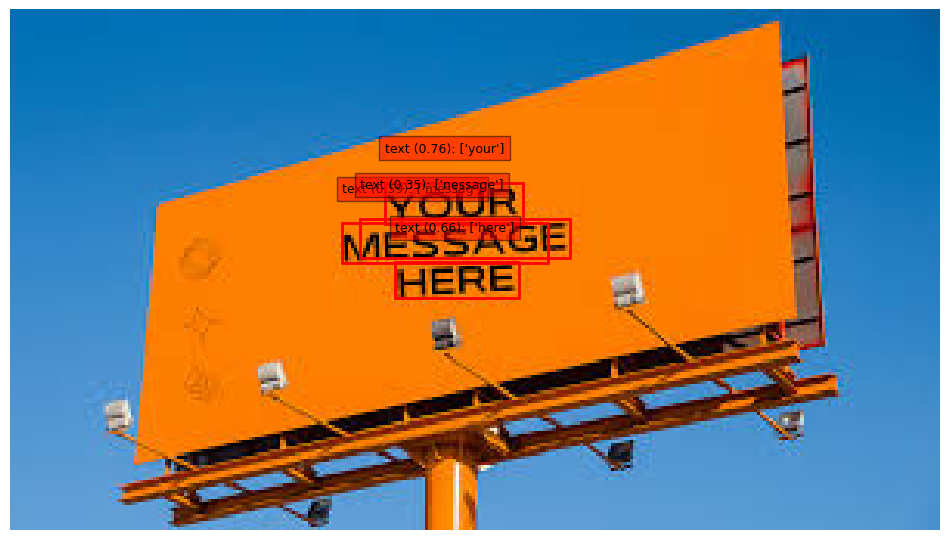

In [17]:
img_path = "/content/images.jpeg"
inf_transforms = data_transforms["val"]

predictions = predict(
        img_path,
        data_transforms=inf_transforms,
        text_det_model=yolo,
        text_reg_model=crnn_model,
        idx_to_char=idx_to_char,
        device=device,
    )